In [37]:
import pandas as pd
import numpy as np
import time
from math import radians, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import requests
from geopy.distance import geodesic
import joblib

In [38]:
data = pd.read_csv('D:\DISHWISE\DishWise-main\scripts\FINAL.csv')
geo_data = pd.read_csv('D:\DISHWISE\DishWise-main\scripts\location.csv')
data = pd.merge(data, geo_data, how='left', on='District')

In [39]:
le_district = LabelEncoder()
le_commodity = LabelEncoder()
le_variety = LabelEncoder()

data['District_Encoded'] = le_district.fit_transform(data['District'])
data['Commodity_Encoded'] = le_commodity.fit_transform(data['Commodity'])
data['Variety_Encoded'] = le_variety.fit_transform(data['Variety'])


data['Year'] = pd.DatetimeIndex(data['Year']).year
month_name_to_number = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5,
    'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,
    'November': 11, 'December': 12
}

data['Month'] = data['Month_Name'].map(month_name_to_number)
data = data.dropna(subset=['Commodity_Encoded', 'Variety_Encoded', 'District_Encoded', 'Year', 'Month', 'Modal_Price'])

In [40]:

features = ['Commodity_Encoded', 'Variety_Encoded', 'District_Encoded', 'Year', 'Month']
target = 'Modal_Price'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],                  # Number of trees
    'max_depth': [None, 10, 20, 30, 50],                  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],                      # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],                        # Minimum number of samples required at a leaf node
    'bootstrap': [True, False]                            # Whether bootstrap samples are used
}


In [42]:

rf_model = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, 
                                   param_distributions=param_grid, 
                                   n_iter=100,       # Number of iterations
                                   cv=5,             # 5-fold cross-validation
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1)        # Use all available cores

# Start timer for training
start_train_time = time.time()

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# End timer for training
end_train_time = time.time()
training_time = end_train_time - start_train_time


Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [43]:
# Extract the best model
best_rf_model = random_search.best_estimator_

# Evaluate the best model
y_train_pred = best_rf_model.predict(X_train)
y_test_pred = best_rf_model.predict(X_test)

# Print best hyperparameters found
print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Training time: {training_time:.4f} seconds")

# Model performance metrics can be calculated here for training and test sets

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': True}
Training time: 463.0500 seconds


In [44]:
import joblib

# Save the best model from RandomizedSearchCV to a file
joblib.dump(best_rf_model, 'random_forest_model.pkl')

print("Model saved as 'random_forest_model.pkl'")


Model saved as 'random_forest_model.pkl'


In [45]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0 
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    a = sin(dLat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dLon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [46]:
import requests
from geopy.distance import geodesic

# Function to get latitude and longitude using OpenStreetMap Nominatim API
def get_lat_lon_from_district(district_name):
    url = f"https://nominatim.openstreetmap.org/search?q={district_name}&format=json"
    response = requests.get(url)
    data = response.json()
    
    if data:
        lat = float(data[0]['lat'])
        lon = float(data[0]['lon'])
        return lat, lon
    else:
        raise ValueError(f"Could not find coordinates for {district_name}")

# Updated haversine function (using geopy to calculate distance accurately)
def calculate_distance(lat1, lon1, lat2, lon2):
    loc1 = (lat1, lon1)
    loc2 = (lat2, lon2)
    return geodesic(loc1, loc2).kilometers  # More accurate calculation using geodesic distance

# Use the API to get latitude and longitude dynamically
def predict_prices(chosen_commodity, chosen_variety, chosen_district, quantity, chosen_month, chosen_year):
    # Fetch latitude and longitude using OpenStreetMap API for the chosen district
    try:
        current_lat, current_lon = get_lat_lon_from_district(chosen_district)
    except ValueError as e:
        print(e)
        return
    
    district_encoded = le_district.transform([chosen_district])[0]
    commodity_encoded = le_commodity.transform([chosen_commodity])[0]
    variety_encoded = le_variety.transform([chosen_variety])[0]

    input_data = pd.DataFrame({
        'Commodity_Encoded': [commodity_encoded],
        'Variety_Encoded': [variety_encoded],
        'District_Encoded': [district_encoded],
        'Year': [chosen_year],
        'Month': [chosen_month]
    })

    predicted_price = rf_model.predict(input_data)[0]
    print(f"Predicted price for {chosen_commodity} in {chosen_district} for {chosen_month}/{chosen_year}: ₹{predicted_price:.2f} per quintal")
    total_cost = (predicted_price / 100) * quantity
    print(f"For {quantity} kg, the estimated total cost is: ₹{total_cost:.2f}")
    
    # Calculate distances from nearby districts
    data['distance'] = data.apply(lambda row: calculate_distance(current_lat, current_lon, row['avg_latitude'], row['avg_longitude']), axis=1)
    
    best_month_data = data[(data['Commodity'] == chosen_commodity) & (data['Variety'] == chosen_variety)]
    
    if not best_month_data.empty:
        best_buy_month_row = best_month_data.groupby('Month')['Modal_Price'].mean().idxmin()
        best_buy_month = pd.to_datetime(f'2023-{best_buy_month_row}-01').month_name()  
        print(f"The best buy month for {chosen_commodity} ({chosen_variety}) is {best_buy_month}.")
    else:
        print("No data available for the selected commodity and variety.")

    nearby_districts = data[(data['Commodity'] == chosen_commodity) &
                             (data['Variety'] == chosen_variety) &
                             (data['District'] != chosen_district)] \
                         .sort_values(by=['distance', 'Modal_Price']).drop_duplicates(subset='District').head(3)
    
    if not nearby_districts.empty:
        print("Nearby districts with best prices:")
        for _, row in nearby_districts.iterrows():
            nearby_district = row['District']
            nearby_distance = row['distance']
            nearby_price = float(row['Modal_Price']) / 100 * quantity
            print(f"- {nearby_district} ({nearby_distance:.2f} km), Price: ₹{nearby_price:.2f} for {quantity} kg")
    else:
        print("No nearby districts found with available data.")


In [51]:
def predict_prices(chosen_commodity, chosen_variety, chosen_district, quantity, chosen_month, chosen_year):
    district_encoded = le_district.transform([chosen_district])[0]
    commodity_encoded = le_commodity.transform([chosen_commodity])[0]
    variety_encoded = le_variety.transform([chosen_variety])[0]

    input_data = pd.DataFrame({
        'Commodity_Encoded': [commodity_encoded],
        'Variety_Encoded': [variety_encoded],
        'District_Encoded': [district_encoded],
        'Year': [chosen_year],
        'Month': [chosen_month]
    })

    start_predict_time = time.time()
    predicted_price = best_rf_model.predict(input_data)[0]
    end_predict_time = time.time()
    prediction_time = end_predict_time - start_predict_time
  
    print(f"Predicted price for {chosen_commodity} in {chosen_district} for {chosen_month}/{chosen_year}: ₹{predicted_price:.2f} per quintal")
    
    total_cost = (predicted_price / 100) * quantity
    print(f"For {quantity} kg, the estimated total cost is: ₹{total_cost:.2f}")

    # Get the current latitude and longitude for the chosen district
    current_lat = geo_data[geo_data['District'] == chosen_district]['avg_latitude'].values[0]
    current_lon = geo_data[geo_data['District'] == chosen_district]['avg_longitude'].values[0]

    # Calculate distances to all other districts
    data['distance'] = data.apply(lambda row: haversine(current_lat, current_lon, row['avg_latitude'], row['avg_longitude']), axis=1)

    # Determine the best buy month
    best_month_data = data[(data['Commodity'] == chosen_commodity) & (data['Variety'] == chosen_variety)]
    
    if not best_month_data.empty:
        best_buy_month_row = best_month_data.groupby('Month')['Modal_Price'].mean().idxmin()
        best_buy_month = pd.to_datetime(f'2023-{best_buy_month_row}-01').month_name()  
        print(f"The best buy month for {chosen_commodity} ({chosen_variety}) is {best_buy_month}.")
    else:
        print("No data available for the selected commodity and variety.")

    # Find nearby districts with best prices
    nearby_districts = data[(data['Commodity'] == chosen_commodity) &
                             (data['Variety'] == chosen_variety) &
                             (data['District'] != chosen_district)] \
                         .sort_values(by=['distance', 'Modal_Price']).drop_duplicates(subset='District').head(3)
    
    if not nearby_districts.empty:
        print("Nearby districts with best prices:")
        for _, row in nearby_districts.iterrows():
            nearby_district = row['District']
            nearby_distance = row['distance']
            nearby_price = float(row['Modal_Price']) / 100 * quantity
            print(f"- {nearby_district} ({nearby_distance:.2f} km), Price: ₹{nearby_price:.2f} for {quantity} kg")
    else:
        print("No nearby districts found with available data.")

In [49]:
chosen_commodity = input("Enter the commodity (e.g., Groundnut): ")
chosen_variety = input("Enter the variety (e.g., Other): ")
chosen_district = input("Enter the district (e.g., Ariyalur): ")
quantity = float(input("Enter the quantity in kg (e.g., 2): "))
chosen_month = int(input("Enter the month as a number (1-12, e.g., 6 for June): "))
chosen_year = int(input("Enter the year (e.g., 2023): "))

In [52]:
predict_prices(chosen_commodity, chosen_variety, chosen_district, quantity, chosen_month, chosen_year)

Predicted price for Turmeric in Coimbatore for 3/2024: ₹7364.90 per quintal
For 1.0 kg, the estimated total cost is: ₹73.65
The best buy month for Turmeric (Bulb) is November.
Nearby districts with best prices:
- Erode (57.84 km), Price: ₹48.17 for 1.0 kg
- Karur (110.77 km), Price: ₹39.00 for 1.0 kg
- Namakkal (127.75 km), Price: ₹48.98 for 1.0 kg


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_train_pred = best_rf_model.predict(X_train)
y_test_pred = best_rf_model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)


train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Training MAE: {train_mae}, Test MAE: {test_mae}')
print(f'Training RMSE: {train_rmse}, Test RMSE: {test_rmse}')
print(f'Training R²: {train_r2}, Test R²: {test_r2}')


Training MAE: 1012.8252139049515, Test MAE: 1083.4280407633478
Training RMSE: 6086.630559862142, Test RMSE: 2289.3807858258756
Training R²: 0.36938020355140155, Test R²: 0.7332052342614219


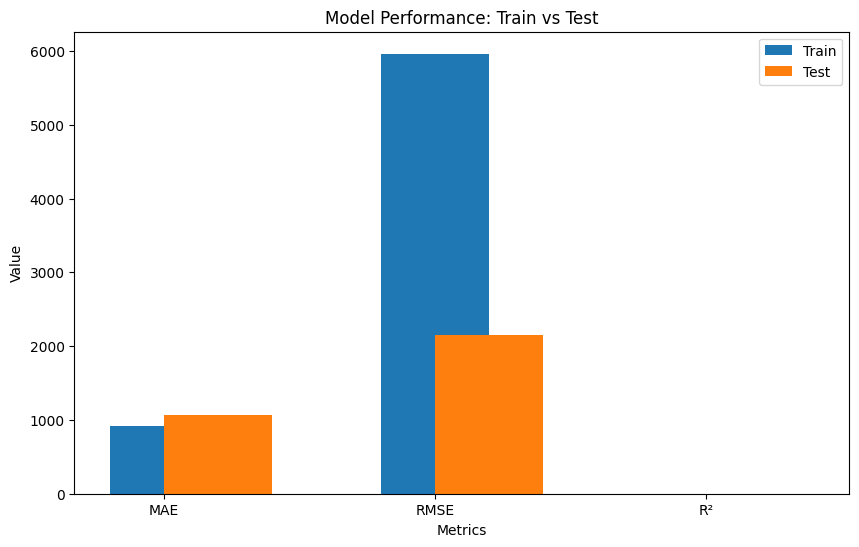

In [23]:
import matplotlib.pyplot as plt

# Metrics to plot
metrics = ['MAE', 'RMSE', 'R²']
train_metrics = [train_mae, train_rmse, train_r2]
test_metrics = [test_mae, test_rmse, test_r2]

# Plotting the metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics, train_metrics, width=0.4, label='Train', align='center')
plt.bar(metrics, test_metrics, width=0.4, label='Test', align='edge')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Performance: Train vs Test')
plt.legend()
plt.show()
